In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import time
from datetime import datetime
import networkx as nx
import torch
import torch.optim as optim
import numpy as np
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [7]:
class Encoder(torch.nn.Module):
    '''
    Encoder : Graph Conv to get embeddings 
    Decoder : inner product 
    '''

    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)    # reconstruction loss 
    loss.backward()
    optimizer.step()
    
    #tensorboard
    writer.add_scalar("loss", loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)
#tensorboard
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid("/tmp/citeseer", "Citeseer", transform = T.NormalizeFeatures())
data = dataset[0]

data


Data(edge_index=[2, 9104], test_mask=[3327], train_mask=[3327], val_mask=[3327], x=[3327, 3703], y=[3327])

In [8]:
channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())
# encoder: written by us; decoder: default (inner product)
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None

# data = model.split_edges(data) # split_edges unavilable 
data = pyg_utils.train_test_split_edges(data, val_ratio=0, test_ratio=0.2)   # construct positive/negative edges (for negative sampling!)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
data

CUDA availability: True


Data(test_neg_edge_index=[2, 455], test_pos_edge_index=[2, 455], train_neg_adj_mask=[3327, 3327], train_pos_edge_index=[2, 7740], val_neg_edge_index=[2, 227], val_pos_edge_index=[2, 227], x=[3327, 3703])

In [17]:
for epoch in range(1, 201):
    train(epoch)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 010, AUC: 0.6332, AP: 0.7069
Epoch: 020, AUC: 0.7813, AP: 0.7852
Epoch: 030, AUC: 0.7926, AP: 0.7955
Epoch: 040, AUC: 0.7965, AP: 0.7970
Epoch: 050, AUC: 0.8085, AP: 0.8123
Epoch: 060, AUC: 0.8483, AP: 0.8483
Epoch: 070, AUC: 0.8507, AP: 0.8508
Epoch: 080, AUC: 0.8463, AP: 0.8462
Epoch: 090, AUC: 0.8459, AP: 0.8498
Epoch: 100, AUC: 0.8473, AP: 0.8508
Epoch: 110, AUC: 0.8492, AP: 0.8548
Epoch: 120, AUC: 0.8462, AP: 0.8545
Epoch: 130, AUC: 0.8471, AP: 0.8555
Epoch: 140, AUC: 0.8507, AP: 0.8586
Epoch: 150, AUC: 0.8611, AP: 0.8710
Epoch: 160, AUC: 0.8704, AP: 0.8807
Epoch: 170, AUC: 0.8674, AP: 0.8798
Epoch: 180, AUC: 0.8655, AP: 0.8777
Epoch: 190, AUC: 0.8638, AP: 0.8766
Epoch: 200, AUC: 0.8651, AP: 0.8772


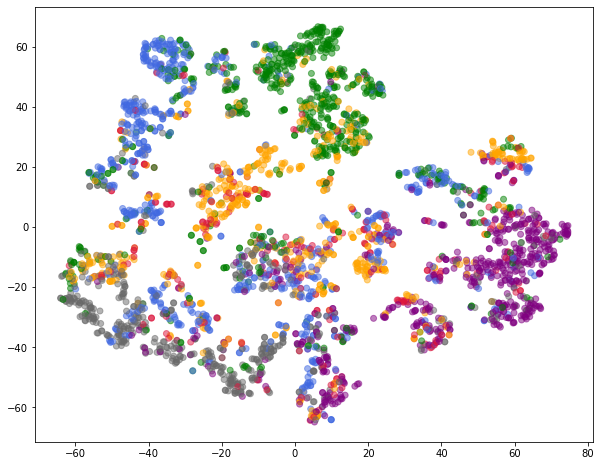

In [3]:
color_list = ["crimson", "orange", "green", "royalblue", "purple", "dimgrey", "gold"]
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))

plt.figure(figsize=(10, 8))
plt.scatter(xs, ys, color=colors, alpha=0.5)
plt.show()

In [ ]:
#cmd
#tensorboard --logdir=./log/20210329-141813/ --port 6006